In [138]:
import pandas as pd

In [139]:
files = ["./data/orochi_data/clapping.txt",
         "./data/orochi_data/fingersnap.txt",]

dfs = []

for idx, file in enumerate(files):
    with open(file, "r") as f:
        lines = f.readlines()
        df = pd.DataFrame([x.split() for x in lines[0:120]])
        df.drop(columns=[0, 1, 2, 3, 4, 5, 8, 9], inplace=True)
        # add another column with the file name
        df["gesture"] = idx
        df.columns = ["f1", "f2", "gesture"]
        dfs.append(df)

In [140]:
df = pd.DataFrame()
for d in dfs:
    df = pd.concat([df, d], ignore_index=True)
    
X = df[["f1", "f2"]]
y = df["gesture"]

In [141]:
# convert X from hex string to int
X = X.map(lambda x: int(x, 16))

In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [229]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

shape = (2,3,2)

model = Sequential([
    Dense(shape[1], activation='relu', input_shape=(shape[0],), name="hidden"),
    Dense(shape[2], activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Pyth\radarobj_detection\radarml\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [232]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',   # or use 'accuracy' if you want training accuracy
    patience=40,               # number of epochs with no improvement after which training will be stopped
    mode='max',
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    epochs=400,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)



Epoch 1/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5141 - loss: 5.3503 - val_accuracy: 0.3846 - val_loss: 6.2097
Epoch 2/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5046 - loss: 4.9695 - val_accuracy: 0.3846 - val_loss: 5.7148
Epoch 3/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5211 - loss: 4.2868 - val_accuracy: 0.3846 - val_loss: 5.2240
Epoch 4/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5406 - loss: 3.8270 - val_accuracy: 0.3846 - val_loss: 4.7279
Epoch 5/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5150 - loss: 3.6968 - val_accuracy: 0.3846 - val_loss: 4.2245
Epoch 6/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5076 - loss: 3.2701 - val_accuracy: 0.3846 - val_loss: 3.7239
Epoch 7/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5706 - loss: 2.4943 - val_accuracy: 0.3846 - val_loss: 3.2361
Epoch 8/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5376 - loss: 2.3297 - val_accuracy: 0.3846 - val_loss:

In [234]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9271 - loss: 0.3330
Test Accuracy: 0.9375


In [235]:
from sklearn.metrics import classification_report

targets = ['clapping', 'fingersnap']

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)  # convert from probabilities to class indices

# Print report
print(classification_report(y_test, y_pred_classes, target_names=targets))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
              precision    recall  f1-score   support

    clapping       1.00      0.88      0.93        24
  fingersnap       0.89      1.00      0.94        24

    accuracy                           0.94        48
   macro avg       0.94      0.94      0.94        48
weighted avg       0.94      0.94      0.94        48



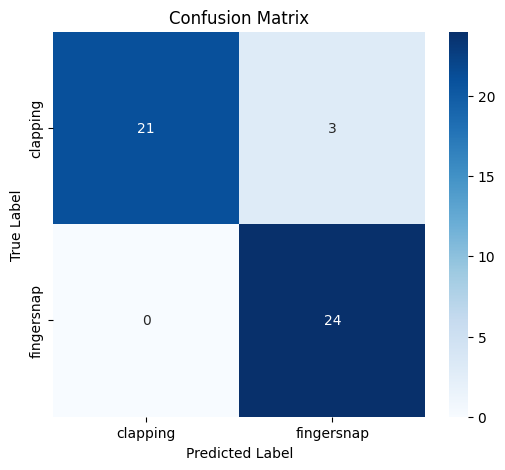

In [236]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=targets,
            yticklabels=targets)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()


In [237]:
import re
import numpy as np

def parse_weights(input_str):
    # Regex to match variable entries
    pattern = r"<Variable path=(.*?), shape=(.*?), dtype=.*?, value=([\s\S]*?)>"

    matches = re.findall(pattern, input_str)
    weights_dict = {}
    labels = ["input_hidden_weights", "hidden_biases", "hidden_output_weights", "output_biases"]
    idx = 0
    for var_name, var_shape, value_str in matches:
        # get the shape
        var_shape = tuple(int(dim) for dim in var_shape.strip('()').split(',') if dim)
        # Clean up variable name
        var_name = var_name.strip()
        cleaned_value = re.sub(r'\s+', ' ', value_str.strip())
        cleaned_value = cleaned_value.replace('[', '')
        cleaned_value = cleaned_value.replace(']', '')
        cleaned_value = cleaned_value.strip().split(' ')
        cleaned_value = [float(x) for x in cleaned_value if x]  # Convert to float and remove empty strings
        value = np.array(cleaned_value).reshape(var_shape)
        weights_dict[labels[idx]] = value
        idx += 1

    return weights_dict


In [238]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

def evaluate_custom_mlp(X, y, weights_dict, is_categorical=False, shape=(5, 8, 2)):
    """
    Evaluate accuracy of a manually-weighted MLP model.

    Parameters:
        X (np.ndarray): Input data, shape (num_samples, 4)
        y (np.ndarray): Labels, shape (num_samples,) or one-hot (num_samples, 3)
        weights_dict (dict): Dictionary with keys:
            'input_hidden_weights', 'hidden_biases',
            'hidden_output_weights', 'output_biases'
        is_categorical (bool): Set True if y is one-hot encoded

    Returns:
        float: Accuracy score
    """

    # 1. Build model with matching architecture
    model = Sequential([
        Dense(shape[1], input_shape=(shape[0],), activation='relu', name='hidden'),
        Dense(shape[2], activation='softmax', name='output')
    ])

    # 2. Set custom weights
    model.get_layer('hidden').set_weights([
        np.array(weights_dict['input_hidden_weights']),
        np.array(weights_dict['hidden_biases'])
    ])

    model.get_layer('output').set_weights([
        np.array(weights_dict['hidden_output_weights']),
        np.array(weights_dict['output_biases'])
    ])

    # 3. Get predictions
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)

    # 4. Process ground truth
    if is_categorical:
        true_classes = np.argmax(y, axis=1)
    else:
        true_classes = y

    # 5. Compute accuracy
    accuracy = accuracy_score(true_classes, predicted_classes)
    return accuracy


In [239]:
import numpy as np

def round_weights(weights_dict, decimals=2, scale=0):
    """
    Rounds all numpy array values in the input dictionary to the given number of decimals,
    with an optional scaling factor applied before rounding.

    Parameters:
        weights_dict (dict): Dictionary with keys mapping to numpy arrays.
        decimals (int): Number of decimal places to round to.
        scale (int): Power of 10 to scale the values before rounding. For example,
                     scale=2 multiplies values by 100 before rounding.

    Returns:
        dict: New dictionary with rounded values.
    """
    rounded_dict = {}
    factor = 10 ** scale

    for key, value in weights_dict.items():
        if isinstance(value, np.ndarray):
            scaled = value * factor
            rounded = np.round(scaled, decimals)
            rounded_dict[key] = rounded
        else:
            rounded_dict[key] = value  # Leave untouched if not an ndarray

    return rounded_dict


In [240]:
parse_weights(str(model.weights))

{'input_hidden_weights': array([[ 0.2594299 , -0.3768168 ,  0.8956291 ],
        [-0.0190575 , -0.21202719, -0.18962584]]),
 'hidden_biases': array([-0.06014738,  0.        ,  0.09794158]),
 'hidden_output_weights': array([[ 0.6538672 , -0.07457413],
        [ 0.07928085,  0.85269606],
        [-0.46889642, -0.01549624]]),
 'output_biases': array([-0.06184732,  0.06184732])}

In [241]:
new_weights = round_weights(parse_weights(str(model.weights)), decimals=0 , scale=2)
new_weights

{'input_hidden_weights': array([[ 26., -38.,  90.],
        [ -2., -21., -19.]]),
 'hidden_biases': array([-6.,  0., 10.]),
 'hidden_output_weights': array([[ 65.,  -7.],
        [  8.,  85.],
        [-47.,  -2.]]),
 'output_biases': array([-6.,  6.])}

In [242]:
accuracy = evaluate_custom_mlp(X, y, new_weights, is_categorical=False, shape=shape)
print("Accuracy:", accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy: 0.9083333333333333


c:\Pyth\radarobj_detection\radarml\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
